# Revisão Modelo SEIR 

In [3]:
import pandas as pd
import yaml
import requests
from pathlib import Path
import numpy as np

%load_ext autoreload
%autoreload 2

In [4]:
# Atualizado em: 09/09/2020
# df = pd.read_csv("http://45.55.43.231:7000/br/health_region/farolcovid/main")
# df.to_csv("data/br_health_region_farolcovid_"+df["data_last_refreshed"].unique()[0][:10].replace("-", "")+".csv")

## Dados e config

In [3]:
df = pd.read_csv("data/br_health_region_farolcovid_20200909.csv", index_col=0)
df = df.sort_values(by=["health_region_id"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 449
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   active_cases                  449 non-null    float64
 1   author_number_beds            450 non-null    object 
 2   author_number_icu_beds        450 non-null    object 
 3   capacity_classification       449 non-null    float64
 4   confirmed_cases               450 non-null    float64
 5   control_classification        439 non-null    float64
 6   country_iso                   450 non-null    object 
 7   country_name                  450 non-null    object 
 8   daily_cases                   450 non-null    float64
 9   daily_cases_growth            450 non-null    object 
 10  daily_cases_growth_ndays      450 non-null    int64  
 11  daily_cases_mavg_100k         441 non-null    float64
 12  dday_icu_beds                 449 non-null    float64
 13  death

In [24]:
url = "https://raw.githubusercontent.com/ImpulsoGov/farolcovid/farol-v2/src/configs/config.yaml"
config = yaml.load(requests.get(url).text, Loader=yaml.FullLoader)

In [5]:
place_id = "health_region_id"

## Inicialização

### Parâmetros de entrada

- Hospitalização
- Populacionais

In [62]:
import get_health_region_parameters 

In [63]:
place_specific_params = get_health_region_parameters.now(config)
place_specific_params

,hospitalized_by_age_perc,i2_percentage,i3_percentage,i1_percentage,fatality_ratio
health_region_id,,,,,
11001,0.033867,0.028028,0.005839,0.966133,0.004345
11002,0.038037,0.031479,0.006558,0.961963,0.005289
11003,0.038577,0.031926,0.006651,0.961423,0.005481
11004,0.032642,0.027014,0.005628,0.967358,0.003829
11005,0.038373,0.031757,0.006616,0.961627,0.005314
...,...,...,...,...,...
52015,0.038205,0.031618,0.006587,0.961795,0.005466
52016,0.040616,0.033614,0.007003,0.959384,0.006176
52017,0.045149,0.037365,0.007784,0.954851,0.007306


In [8]:
df = df.set_index("health_region_id").dropna(subset=["notification_rate"])

In [17]:
import collections

def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [18]:
import prepare_params

In [25]:
t = (df.apply(lambda row: prepare_params.main(row, place_id, config, place_specific_params), axis=1))
t
# (pd.DataFrame([flatten(i) for i in t])
# .join(df.reset_index()["health_region_id"])
# .set_index("health_region_id"))

health_region_id
11001    {'population_params': {'N': 274136, 'I': 2418,...
11002    {'population_params': {'N': 172081, 'I': 262, ...
11003    {'population_params': {'N': 343113, 'I': 4437,...
11004    {'population_params': {'N': 643452, 'I': 3451,...
11005    {'population_params': {'N': 135877, 'I': 322, ...
                               ...                        
52015    {'population_params': {'N': 466594, 'I': 4713,...
52016    {'population_params': {'N': 232723, 'I': 1486,...
52017    {'population_params': {'N': 253654, 'I': 1188,...
52018    {'population_params': {'N': 182595, 'I': 1487,...
53001    {'population_params': {'N': 3015268, 'I': 3282...
Length: 449, dtype: object

### Estados iniciais

In [26]:
import seir
config["br"]["seir_parameters"]

{'asymptomatic_proportion': 0.4,
 'mild_duration': 6,
 'severe_duration': 6,
 'critical_duration': 8,
 'fatality_ratio': 0.02,
 'doubling_rate': 1.15,
 'incubation_period': 5,
 'i1_percentage': 0.855,
 'i2_percentage': 0.12,
 'i3_percentage': 0.025,
 'infected_health_care_proportion': 0.05,
 'hospitalized_by_age_perc': {'from_0_to_9': 2e-05,
  'from_10_to_19': 0.0004,
  'from_20_to_29': 0.011,
  'from_30_to_39': 0.034,
  'from_40_to_49': 0.043,
  'from_50_to_59': 0.082,
  'from_60_to_69': 0.118,
  'from_70_to_79': 0.166,
  'from_80_to_older': 0.184},
 'ifr_by_age_perc': {'from_0_to_9': 2e-05,
  'from_10_to_19': 6e-05,
  'from_20_to_29': 0.0003,
  'from_30_to_39': 0.0008,
  'from_40_to_49': 0.0015,
  'from_50_to_59': 0.006,
  'from_60_to_69': 0.022,
  'from_70_to_79': 0.051,
  'from_80_to_older': 0.093}}

In [28]:
initial_states = pd.DataFrame([i for i in t.apply(lambda row: seir.prepare_states(row["population_params"], 
                                        row["place_specific_params"],
                                        config["br"]["seir_parameters"]))],
            index=t.index)

initial_states

,S,E,I1,I2,I3,R,D
health_region_id,,,,,,,
11001,2.438179e+05,1752.082141,2336.109521,67.771431,14.119048,26033,115
11002,1.684700e+05,189.025744,252.034326,8.247454,1.718220,3112,48
11003,2.657276e+05,3199.375296,4265.833728,141.654846,29.511426,69609,140
11004,5.445182e+05,2503.763498,3338.351331,93.226485,19.422184,92204,775
11005,1.313398e+05,232.232914,309.643886,10.225750,2.130365,3948,35
...,...,...,...,...,...,...,...
52015,3.823543e+05,3399.706021,4532.941361,149.014046,31.044593,75824,303
52016,2.222648e+05,1069.233009,1425.644012,49.949783,10.406205,7790,113
52017,2.393752e+05,850.772268,1134.363024,44.389221,9.247754,12137,103


In [30]:
initial_states = initial_states.join(df[["population", "confirmed_cases", "number_beds", "number_icu_beds"]])
initial_states["population_incidence"] = (initial_states["I1"] + initial_states["I2"] + initial_states["I3"]) / initial_states["population"]

In [31]:
(100*initial_states["population_incidence"]).describe()

count    449.000000
mean       0.750374
std        1.748746
min        0.015749
25%        0.107914
50%        0.208135
75%        0.524659
max       16.216074
Name: population_incidence, dtype: float64

In [32]:
initial_states["is_over_beds"] = initial_states["I2"] >= initial_states["number_beds"]
initial_states["is_over_beds"].value_counts()

False    419
True      30
Name: is_over_beds, dtype: int64

In [33]:
initial_states["is_over_icu_beds"] = initial_states["I3"] >= initial_states["number_icu_beds"]
initial_states["is_over_icu_beds"].value_counts()

False    285
True     164
Name: is_over_icu_beds, dtype: int64

#### Incidência estimada na população em regionais com e sem sobrehospitalização de leitos

In [34]:
# sobrehospitalizadas
(100*initial_states.query("is_over_beds == True")["population_incidence"]).describe()

count    30.000000
mean      6.124530
std       3.455882
min       1.262342
25%       3.998084
50%       5.331907
75%       8.330197
max      16.216074
Name: population_incidence, dtype: float64

In [35]:
# não sobrehospitalizadas
(100*initial_states.query("is_over_beds == False")["population_incidence"]).describe()

count    419.000000
mean       0.365589
std        0.477234
min        0.015749
25%        0.104777
50%        0.191718
75%        0.400004
max        3.164281
Name: population_incidence, dtype: float64

#### Número de mortes em regionais com e sem sobrehospitalização de leitos

In [36]:
# sobrehospitalizadas
(100*initial_states.query("is_over_beds == True")["D"]).describe()

count        30.000000
mean      27183.333333
std       48965.731038
min        3300.000000
25%        5175.000000
50%       12200.000000
75%       16775.000000
max      246100.000000
Name: D, dtype: float64

In [37]:
# não sobrehospitalizadas
(100*initial_states.query("is_over_beds == False")["D"]).describe()

count    4.190000e+02
mean     2.789427e+04
std      9.535194e+04
min      1.000000e+02
25%      3.450000e+03
50%      7.800000e+03
75%      1.885000e+04
max      1.246900e+06
Name: D, dtype: float64

In [38]:
2.789427 * (10**4), 9.535194 * (10**4)

(27894.27, 95351.94)

### Simulação

- Sem sobrehospitalização

In [50]:
import simulator

In [51]:
result = (t.apply(lambda row: simulator.run_simulation(row, config)))
result

health_region_id
11001    {'beds': {'worst': -1, 'best': -1}, 'icu_beds'...
11002    {'beds': {'worst': -1, 'best': -1}, 'icu_beds'...
11003    {'beds': {'worst': -1, 'best': -1}, 'icu_beds'...
11004    {'beds': {'worst': -1, 'best': -1}, 'icu_beds'...
11005    {'beds': {'worst': -1, 'best': -1}, 'icu_beds'...
                               ...                        
52015    {'beds': {'worst': -1, 'best': -1}, 'icu_beds'...
52016    {'beds': {'worst': 77, 'best': -1}, 'icu_beds'...
52017    {'beds': {'worst': 66, 'best': -1}, 'icu_beds'...
52018    {'beds': {'worst': 37, 'best': -1}, 'icu_beds'...
53001    {'beds': {'worst': -1, 'best': -1}, 'icu_beds'...
Length: 449, dtype: object

In [53]:
ddays = (pd.DataFrame([flatten(i) for i in result])
.join(df.reset_index()["health_region_id"])
.set_index("health_region_id")
.replace(-1, 91))

ddays

,beds_worst,beds_best,icu_beds_worst,icu_beds_best
health_region_id,,,,
11001,91,91,91,91
11002,91,91,91,91
11003,91,91,1,1
11004,91,91,91,91
11005,91,91,1,1
...,...,...,...,...
52015,91,91,91,91
52016,77,91,62,91
52017,66,91,36,87


In [54]:
ddays.describe()

,beds_worst,beds_best,icu_beds_worst,icu_beds_best
count,449.000000,449.000000,449.000000,449.000000
mean,69.993318,80.719376,46.512249,55.924276
std,30.051406,28.098148,38.769183,42.928445
min,1.000000,1.000000,1.000000,1.000000
25%,54.000000,91.000000,1.000000,1.000000
50%,91.000000,91.000000,54.000000,91.000000
75%,91.000000,91.000000,91.000000,91.000000
max,91.000000,91.000000,91.000000,91.000000


<AxesSubplot:ylabel='Frequency'>

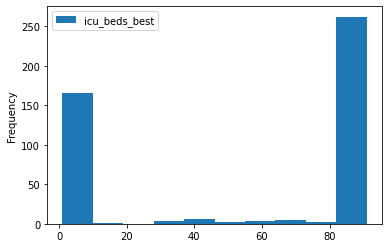

In [57]:
ddays[["icu_beds_best"]].plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

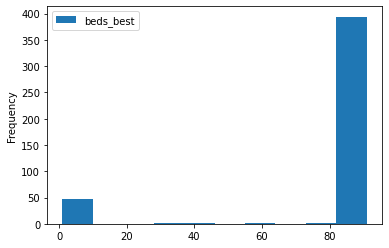

In [60]:
ddays[["beds_best"]].plot(kind="hist")

## Classificação pós mudanças

- Conserto na media movel de casos na subnotificação adicionada em 11/ago

In [81]:
colors = dict(zip(config["br"]["farolcovid"]["categories"].values(), 
                  ["#0990A7", "#F7B502", "#F77800", "#F22E3E"]))
colors

{'novo normal': '#0990A7',
 'moderado': '#F7B502',
 'alto': '#F77800',
 'altíssimo': '#F22E3E'}

### Regionais

In [85]:
df_farol = pd.read_csv("http://45.55.43.231:7000/br/health_region/farolcovid/main")
df_farol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   active_cases                  450 non-null    float64
 1   author_number_beds            450 non-null    object 
 2   author_number_icu_beds        450 non-null    object 
 3   capacity_classification       450 non-null    int64  
 4   confirmed_cases               450 non-null    float64
 5   control_classification        439 non-null    float64
 6   country_iso                   450 non-null    object 
 7   country_name                  450 non-null    object 
 8   daily_cases                   450 non-null    float64
 9   daily_cases_growth            450 non-null    object 
 10  daily_cases_growth_ndays      450 non-null    int64  
 11  daily_cases_mavg_100k         440 non-null    float64
 12  dday_icu_beds                 450 non-null    int64  
 13  death

altíssimo    254
alto         174
moderado       1
Name: overall_alert, dtype: int64


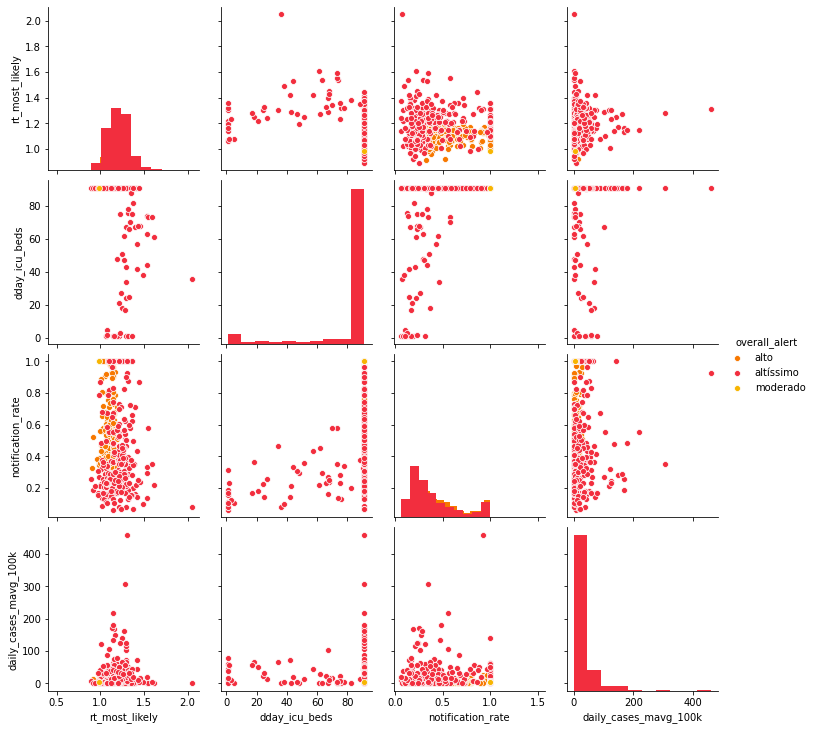

In [86]:
df_farol = df_farol.assign(overall_alert=lambda df:df["overall_alert"].map(config["br"]["farolcovid"]["categories"]))

cols = [
        "rt_most_likely",
        "dday_icu_beds",
        "notification_rate",
        "daily_cases_mavg_100k",
        "overall_alert"
        ]

print(df_farol["overall_alert"].value_counts())

sns.pairplot(df_farol[cols].dropna(), 
                        diag_kind="hist", 
                        hue="overall_alert", 
                        palette=colors)

In [88]:
# cols = [i for i in df_farol.columns if "classification" in i]
df_farol[cols].describe()

,rt_most_likely,dday_icu_beds,notification_rate,daily_cases_mavg_100k
count,439.000000,450.000000,450.000000,440.000000
mean,1.164100,85.602222,0.464396,22.529511
std,0.123773,18.320932,0.263225,55.073928
min,0.890000,1.000000,0.060779,0.000000
25%,1.080000,91.000000,0.258321,2.401396
50%,1.150000,91.000000,0.389039,9.280151
75%,1.230000,91.000000,0.600804,21.474536
max,2.050000,91.000000,1.000000,796.515246


### Estados

In [89]:
df_farol = pd.read_csv("http://45.55.43.231:7000/br/states/farolcovid/main")
df_farol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   active_cases                  27 non-null     float64
 1   author_number_beds            27 non-null     object 
 2   author_number_icu_beds        27 non-null     object 
 3   capacity_classification       27 non-null     int64  
 4   confirmed_cases               27 non-null     float64
 5   control_classification        27 non-null     int64  
 6   country_iso                   27 non-null     object 
 7   country_name                  27 non-null     object 
 8   daily_cases                   27 non-null     float64
 9   daily_cases_growth            27 non-null     object 
 10  daily_cases_growth_ndays      27 non-null     int64  
 11  daily_cases_mavg_100k         27 non-null     float64
 12  dday_icu_beds                 27 non-null     int64  
 13  deaths 

alto         13
altíssimo    11
moderado      3
Name: overall_alert, dtype: int64


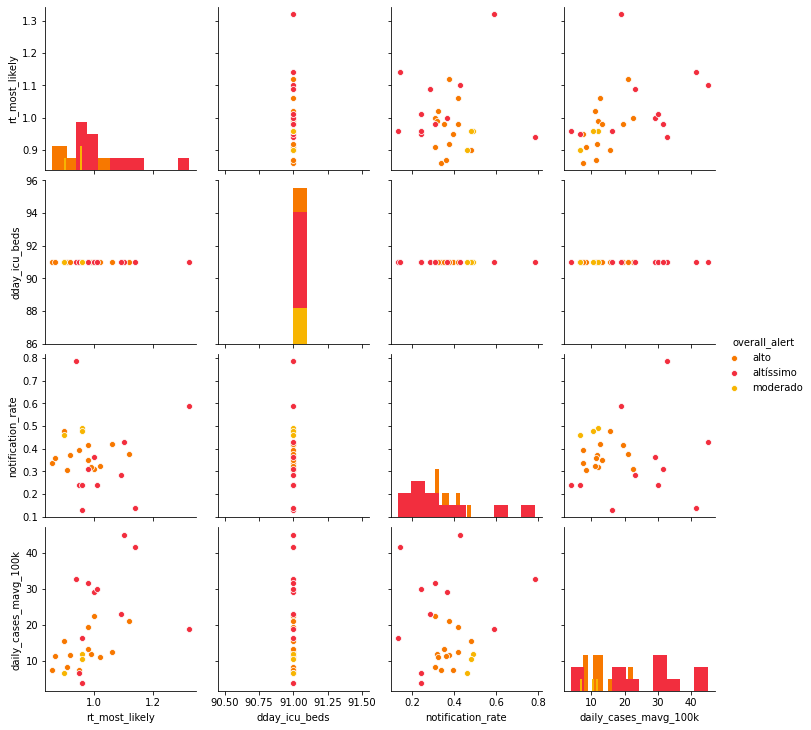

In [90]:
df_farol = df_farol.assign(overall_alert=lambda df:df["overall_alert"].map(config["br"]["farolcovid"]["categories"]))

cols = [
        "rt_most_likely",
        "dday_icu_beds",
        "notification_rate",
        "daily_cases_mavg_100k",
        "overall_alert"
        ]

print(df_farol["overall_alert"].value_counts())

sns.pairplot(df_farol[cols].dropna(), 
                        diag_kind="hist", 
                        hue="overall_alert", 
                        palette=colors)

In [91]:
# cols = [i for i in df_farol.columns if "classification" in i]
df_farol[cols].describe()

,rt_most_likely,dday_icu_beds,notification_rate,daily_cases_mavg_100k
count,27.000000,27.0,27.000000,27.000000
mean,0.993704,91.0,0.368467,17.842735
std,0.097039,0.0,0.133138,10.956272
min,0.860000,91.0,0.129945,3.758483
25%,0.945000,91.0,0.308713,10.856509
50%,0.980000,91.0,0.358100,13.281491
75%,1.015000,91.0,0.424538,22.708527
max,1.320000,91.0,0.785200,45.057875


### Cidades

In [92]:
df_farol = pd.read_csv("http://45.55.43.231:7000/br/cities/farolcovid/main")
df_farol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   active_cases                  5534 non-null   float64
 1   author_number_beds            5570 non-null   object 
 2   author_number_icu_beds        5570 non-null   object 
 3   capacity_classification       5570 non-null   int64  
 4   city_id                       5570 non-null   int64  
 5   city_name                     5570 non-null   object 
 6   confirmed_cases               5550 non-null   float64
 7   control_classification        2440 non-null   float64
 8   country_iso                   5570 non-null   object 
 9   country_name                  5570 non-null   object 
 10  daily_cases                   5550 non-null   float64
 11  daily_cases_growth            5550 non-null   object 
 12  daily_cases_growth_ndays      5550 non-null   float64
 13  dai

altíssimo      1307
alto            722
moderado        373
novo normal      27
Name: overall_alert, dtype: int64


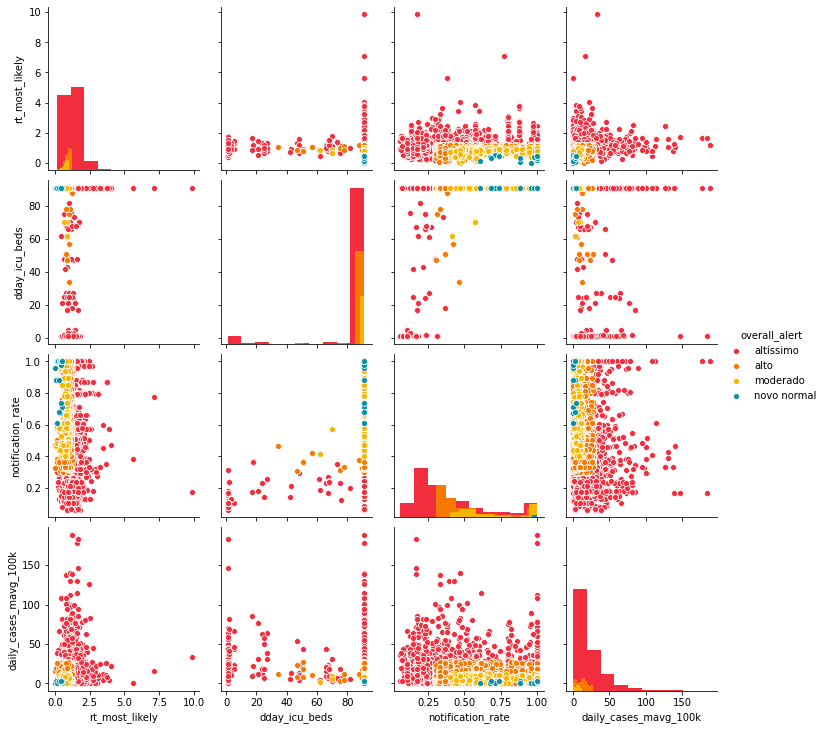

In [93]:
df_farol = df_farol.assign(overall_alert=lambda df:df["overall_alert"].map(config["br"]["farolcovid"]["categories"]))

cols = [
        "rt_most_likely",
        "dday_icu_beds",
        "notification_rate",
        "daily_cases_mavg_100k",
        "overall_alert"
        ]

print(df_farol["overall_alert"].value_counts())

sns.pairplot(df_farol[cols].dropna(), 
                        diag_kind="hist", 
                        hue="overall_alert", 
                        palette=colors)

In [94]:
# cols = [i for i in df_farol.columns if "classification" in i]
df_farol[cols].describe()

,rt_most_likely,dday_icu_beds,notification_rate,daily_cases_mavg_100k
count,2442.000000,5570.000000,5534.000000,5547.000000
mean,1.094869,87.183842,0.472913,12.757270
std,1.191306,15.835331,0.250617,17.796966
min,0.007137,1.000000,0.060465,-72.397437
25%,0.799931,91.000000,0.278193,1.863013
50%,0.986270,91.000000,0.405938,7.127584
75%,1.216925,91.000000,0.602000,16.809790
max,53.014930,91.000000,1.000000,236.372407


### Checando leitos e UTI

In [60]:
cnes = pd.read_csv("http://45.55.43.231:7000/br/cities/cnes")

In [61]:
cnes = cnes.groupby("health_region_id").sum()
cnes[cnes["number_icu_beds"] == 0]

,city_id,female,female-0-19,female-20-29,female-30-39,female-40-49,female-50-59,female-60-69,female-70-79,female-80>,...,male-50-59,male-60-69,male-70-79,male-80>,number_beds,number_covid_icu_beds,number_icu_beds,number_ventilators,population,state_num_id
health_region_id,,,,,,,,,,,,,,,,,,,,,
11005,8803986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,168,0,0,5,135877,88
11007,3303072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,72,0,0,2,50453,33
12001,4801118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,42,14,0,3,71429,48
13002,10409884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,154,3,0,3,297949,104
13003,6508659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,100,16,0,9,199609,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52006,26053101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,85,0,0,5,46464,260
52007,57337880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,119,0,0,9,104943,572
52008,67773369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,263,24,0,10,136519,676


In [65]:
cnes["icu_sum"] = cnes["number_icu_beds"] + cnes["number_covid_icu_beds"]
cnes[cnes["icu_sum"] == 0]

,city_id,female,female-0-19,female-20-29,female-30-39,female-40-49,female-50-59,female-60-69,female-70-79,female-80>,...,male-60-69,male-70-79,male-80>,number_beds,number_covid_icu_beds,number_icu_beds,number_ventilators,population,state_num_id,icu_sum
health_region_id,,,,,,,,,,,,,,,,,,,,,
11005,8803986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,168,0,0,5,135877,88,0
11007,3303072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,72,0,0,2,50453,33,0
13004,7820576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,138,0,0,9,172997,78,0
13005,6510498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,193,0,0,32,250599,65,0
13007,7809322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,110,0,0,4,137818,78,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52003,41680515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,179,0,0,35,269355,416,0
52006,26053101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,85,0,0,5,46464,260,0
52007,57337880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,119,0,0,9,104943,572,0


In [67]:
(cnes["number_icu_beds"] - cnes["number_covid_icu_beds"] == cnes["number_covid_icu_beds"]).value_counts()

False    356
True      94
dtype: int64

In [62]:
cnes[cnes["number_covid_icu_beds"] == 0]

,city_id,female,female-0-19,female-20-29,female-30-39,female-40-49,female-50-59,female-60-69,female-70-79,female-80>,...,male-50-59,male-60-69,male-70-79,male-80>,number_beds,number_covid_icu_beds,number_icu_beds,number_ventilators,population,state_num_id
health_region_id,,,,,,,,,,,,,,,,,,,,,
11005,8803986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,168,0,0,5,135877,88
11007,3303072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,72,0,0,2,50453,33
13004,7820576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,138,0,0,9,172997,78
13005,6510498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,193,0,0,32,250599,65
13007,7809322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,110,0,0,4,137818,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52009,83345459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,226,0,0,22,113882,832
52010,67753085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,178,0,9,15,115958,676
52013,104291600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,498,0,19,40,166102,1040


In [63]:
cnes[cnes["number_beds"] == 0]

,city_id,female,female-0-19,female-20-29,female-30-39,female-40-49,female-50-59,female-60-69,female-70-79,female-80>,...,male-50-59,male-60-69,male-70-79,male-80>,number_beds,number_covid_icu_beds,number_icu_beds,number_ventilators,population,state_num_id
health_region_id,,,,,,,,,,,,,,,,,,,,,


### teste

In [73]:
df_farol = pd.read_csv("http://45.55.43.231:7000/br/cities/farolcovid/main")
df_farol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   active_cases                  5534 non-null   float64
 1   author_number_beds            5570 non-null   object 
 2   author_number_icu_beds        5570 non-null   object 
 3   capacity_classification       5570 non-null   int64  
 4   city_id                       5570 non-null   int64  
 5   city_name                     5570 non-null   object 
 6   confirmed_cases               5550 non-null   float64
 7   control_classification        2440 non-null   float64
 8   country_iso                   5570 non-null   object 
 9   country_name                  5570 non-null   object 
 10  daily_cases                   5550 non-null   float64
 11  daily_cases_growth            5550 non-null   object 
 12  daily_cases_growth_ndays      5550 non-null   float64
 13  dai

altíssimo      1306
alto            723
moderado        373
novo normal      27
Name: overall_alert, dtype: int64


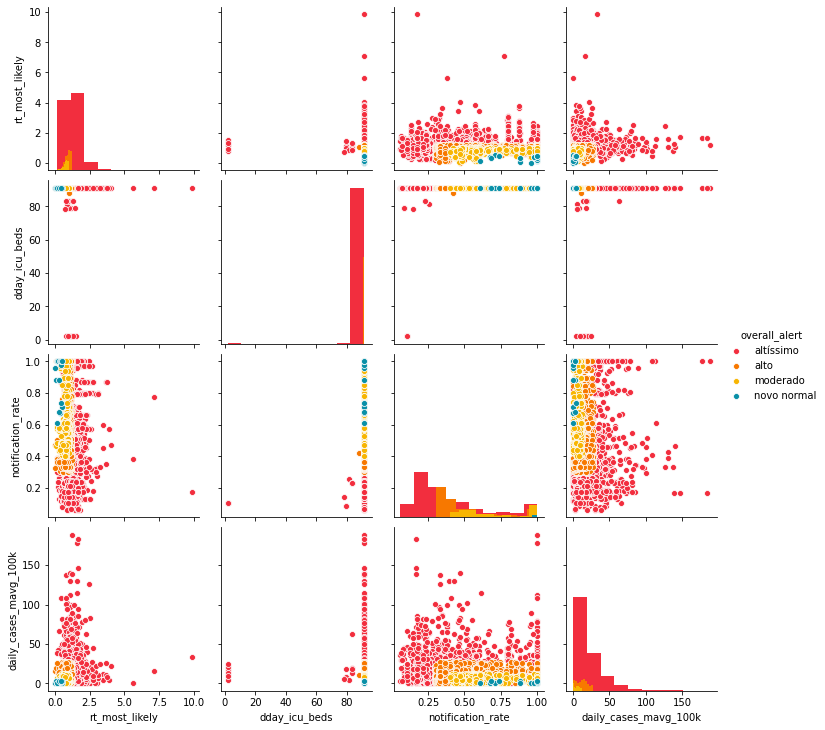

In [74]:
df_farol = df_farol.assign(overall_alert=lambda df:df["overall_alert"].map(config["br"]["farolcovid"]["categories"]))

cols = [
        "rt_most_likely",
        "dday_icu_beds",
        "notification_rate",
        "daily_cases_mavg_100k",
        "overall_alert"
        ]

print(df_farol["overall_alert"].value_counts())

sns.pairplot(df_farol[cols].dropna(), 
                        diag_kind="hist", 
                        hue="overall_alert", 
                        palette=colors)

In [75]:
rt = pd.read_csv("http://45.55.43.231:7000/br/states/rt")
rt[rt["state_num_id"] == 42]

,Rt_high_95,Rt_low_95,Rt_most_likely,Rt_most_likely_growth,Rt_most_likely_mavg,Rt_most_likely_mavg_100k,last_updated,state_num_id,data_last_refreshed


In [79]:
rt = pd.read_csv("http://45.55.43.231:7000/br/states/cases/full")
rt[rt["state_num_id"] == 33].tail(30)

,active_cases,cases_mavg,confirmed_cases,daily_cases,daily_cases_growth,daily_cases_mavg,daily_cases_mavg_100k,deaths,deaths_mavg,estimated_cases,...,new_deaths_growth,new_deaths_mavg,new_deaths_mavg_100k,notification_rate,population,state_id,state_name,state_num_id,total_estimated_cases,data_last_refreshed
3380,170443.0,1731.400000,185610.0,3047.0,estabilizando,1847.3,10.699717,14295.0,84.133333,12315.0,...,estabilizando,62.9,0.364322,0.140593,17264943,RJ,Rio de Janeiro,33,1899791.0,2020-09-11 18:29:04
3381,188135.0,1762.533333,188085.0,2475.0,estabilizando,2003.0,11.601544,14412.0,80.933333,13566.0,...,estabilizando,67.3,0.389807,0.129923,17264943,RJ,Rio de Janeiro,33,1913357.0,2020-09-11 18:29:04
3382,181792.0,1749.933333,189891.0,1806.0,estabilizando,2027.9,11.745767,14507.0,77.266667,13040.0,...,estabilizando,68.4,0.396179,0.134197,17264943,RJ,Rio de Janeiro,33,1926397.0,2020-09-11 18:29:04
3383,170120.0,1674.600000,190614.0,723.0,estabilizando,1727.1,10.003508,14526.0,69.933333,12174.0,...,estabilizando,65.1,0.377065,0.137555,17264943,RJ,Rio de Janeiro,33,1938571.0,2020-09-11 18:29:04
3384,171449.0,1804.400000,194279.0,3665.0,estabilizando,2204.1,12.766332,14562.0,67.066667,11435.0,...,estabilizando,68.9,0.399075,0.157796,17264943,RJ,Rio de Janeiro,33,1950006.0,2020-09-11 18:29:04
3385,158077.0,1828.400000,194651.0,372.0,estabilizando,2090.7,12.109510,14566.0,66.266667,10871.0,...,estabilizando,65.4,0.378802,0.168191,17264943,RJ,Rio de Janeiro,33,1960877.0,2020-09-11 18:29:04
3386,155837.0,2094.400000,199480.0,4829.0,estabilizando,2416.7,13.997729,14728.0,74.933333,10677.0,...,estabilizando,73.7,0.426877,0.196160,17264943,RJ,Rio de Janeiro,33,1971554.0,2020-09-11 18:29:04
3387,142542.0,2272.133333,202993.0,3513.0,estabilizando,2483.3,14.383482,14913.0,79.866667,10684.0,...,estabilizando,88.3,0.511441,0.212667,17264943,RJ,Rio de Janeiro,33,1982238.0,2020-09-11 18:29:04
3388,148163.0,2215.800000,205916.0,2923.0,estabilizando,2547.3,14.754176,15074.0,81.266667,10307.0,...,estabilizando,94.6,0.547931,0.214980,17264943,RJ,Rio de Janeiro,33,1992545.0,2020-09-11 18:29:04
3389,141549.0,2198.133333,207036.0,1120.0,estabilizando,2449.3,14.186551,15202.0,84.066667,9928.0,...,estabilizando,99.3,0.575154,0.221407,17264943,RJ,Rio de Janeiro,33,2002473.0,2020-09-11 18:29:04


In [80]:
#rt = pd.read_csv("http://45.55.43.231:7000/br/states/cases/full")
rt[rt["state_num_id"] == 33].tail(42)

,active_cases,cases_mavg,confirmed_cases,daily_cases,daily_cases_growth,daily_cases_mavg,daily_cases_mavg_100k,deaths,deaths_mavg,estimated_cases,...,new_deaths_growth,new_deaths_mavg,new_deaths_mavg_100k,notification_rate,population,state_id,state_name,state_num_id,total_estimated_cases,data_last_refreshed
3368,144376.0,2061.466667,165495.0,1853.0,estabilizando,1516.6,8.784275,13477.0,108.533333,9834.0,...,estabilizando,117.6,0.681149,0.209626,17264943,RJ,Rio de Janeiro,33,1762598.0,2020-09-11 18:29:04
3369,149955.0,2132.200000,167213.0,1718.0,estabilizando,1645.7,9.532033,13556.0,109.133333,9997.0,...,estabilizando,106.9,0.619174,0.213284,17264943,RJ,Rio de Janeiro,33,1772595.0,2020-09-11 18:29:04
3370,139455.0,2133.000000,167225.0,12.0,estabilizando,1557.1,9.018854,13572.0,110.200000,10364.0,...,estabilizando,105.3,0.609906,0.205809,17264943,RJ,Rio de Janeiro,33,1782959.0,2020-09-11 18:29:04
3371,139655.0,1969.333333,168064.0,839.0,estabilizando,1461.4,8.464552,13604.0,99.333333,10164.0,...,estabilizando,104.0,0.602377,0.193756,17264943,RJ,Rio de Janeiro,33,1793123.0,2020-09-11 18:29:04
3372,128308.0,1860.400000,168911.0,847.0,estabilizando,1324.6,7.672194,13715.0,103.600000,10030.0,...,estabilizando,97.4,0.564149,0.185484,17264943,RJ,Rio de Janeiro,33,1803153.0,2020-09-11 18:29:04
3373,141092.0,1837.800000,172679.0,3768.0,estabilizando,1576.0,9.128324,13855.0,104.133333,10779.0,...,estabilizando,93.9,0.543877,0.170498,17264943,RJ,Rio de Janeiro,33,1813932.0,2020-09-11 18:29:04
3374,158249.0,1696.066667,174064.0,1385.0,estabilizando,1488.9,8.623834,13941.0,99.866667,11921.0,...,estabilizando,84.7,0.490590,0.142276,17264943,RJ,Rio de Janeiro,33,1825853.0,2020-09-11 18:29:04
3375,157867.0,1609.800000,175696.0,1632.0,estabilizando,1457.3,8.440804,14028.0,99.533333,12208.0,...,estabilizando,78.7,0.455837,0.131864,17264943,RJ,Rio de Janeiro,33,1838061.0,2020-09-11 18:29:04
3376,185854.0,1576.333333,178524.0,2828.0,estabilizando,1615.9,9.359429,14070.0,94.400000,12832.0,...,estabilizando,73.4,0.425139,0.122844,17264943,RJ,Rio de Janeiro,33,1850893.0,2020-09-11 18:29:04
3377,173468.0,1543.800000,178850.0,326.0,estabilizando,1660.7,9.618914,14080.0,84.800000,11889.0,...,estabilizando,72.6,0.420505,0.129851,17264943,RJ,Rio de Janeiro,33,1862782.0,2020-09-11 18:29:04
